In [1]:
import numpy as np
import scipy as sp
import pandas as pd

from scipy import optimize

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpt
from data_functions import generate_toy_data, get_bootstrap_data, set_intensity, get_data_to_fit
from data_functions import get_attenuation_parameters


plots needed:
- nb of events vs energy
- 

In [2]:
# input parameters for the simualtions
minE = 10**15 #eV
maxE = 10**18 #eV
gamma = -2.5 # slope of the spectrum

#relation between energy and s38
A = 10**12
B = 1.2

#attenuation true numbers
alpha = 0.919
beta = -1.13

# Minimum zenith angle in degrees
minTheta = 50

#number of events to generate
events = 10000
#number of bins for the zenith 
nr_of_bins = 8

data = generate_toy_data(events, minE, maxE, gamma, A, B, alpha, beta, minTheta)

#print(data)

(array([111.,  92.,  94., 103.,  96.,  98.,  89.,  91.,  96., 104., 106.,
         75.,  90., 110.,  83., 113.,  89., 124., 113.,  90., 108.,  85.,
        119., 111., 100.,  94.,  98.,  97., 102., 107., 110.,  85.,  89.,
         96., 103.,  89., 110., 101.,  96.,  97., 107., 108., 103., 104.,
         95., 100.,  94.,  97., 111.,  94., 103., 106.,  81.,  91., 124.,
        110.,  98., 120., 109.,  98.,  89., 104., 107., 100.,  88.,  99.,
        118., 104.,  82., 106., 101., 102., 106.,  97., 110., 122., 116.,
         87.,  82., 116.,  93.,  95., 100., 115.,  91.,  89.,  82.,  94.,
        117.,  95.,  96.,  99.,  99.,  98., 105.,  99.,  95.,  91., 100.,
         94.]),
 array([0.41320654, 0.4190739 , 0.42494127, 0.43080863, 0.436676  ,
        0.44254336, 0.44841073, 0.45427809, 0.46014546, 0.46601282,
        0.47188019, 0.47774755, 0.48361492, 0.48948228, 0.49534965,
        0.50121701, 0.50708438, 0.51295174, 0.51881911, 0.52468647,
        0.53055384, 0.5364212 , 0.54228857, 0.

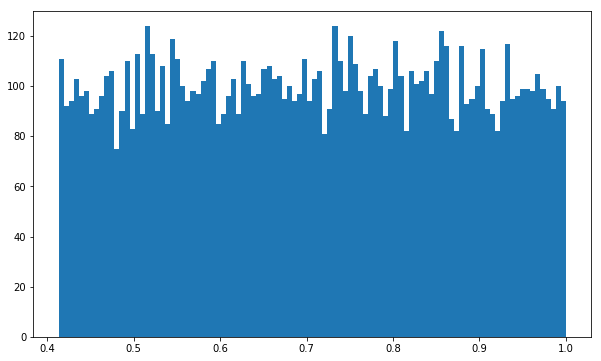

In [3]:
fig1, ax1 =plt.subplots(figsize=(10,6))

ax1.hist(data.cos2,bins=100 )


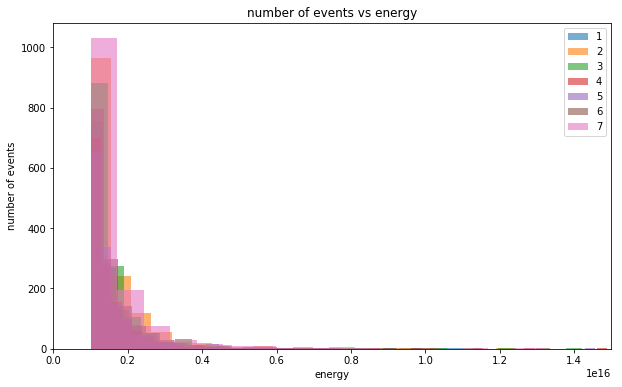

In [10]:
#### fit the attenuation curve
data,groups = set_intensity(data, nr_of_bins)      
#print(groups.size()) 
#print(groups.s125)
#for name, group in groups:
    #do the plotting here
fig2, ax2 =plt.subplots(figsize=(10,6))
groups.energy.plot.hist(bins=50,alpha=0.6,legend=True)
ax2.set_xlim(0,1.5*10**16)
plt.xlabel('energy')
plt.ylabel('number of events')
plt.title('number of events vs energy')
    
    
### input value the reference intensity
intensity = 100
vals, s125_fit, bins2 , s125_fit_error= get_data_to_fit(data, intensity, nr_of_bins)
#print(bins2)
values, cov = get_attenuation_parameters(s125_fit, bins2)

#print(values)

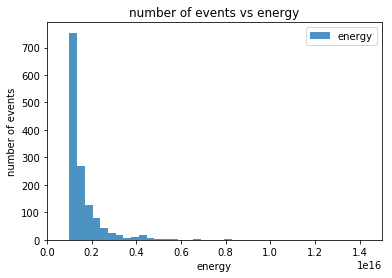

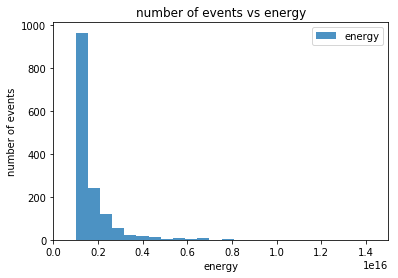

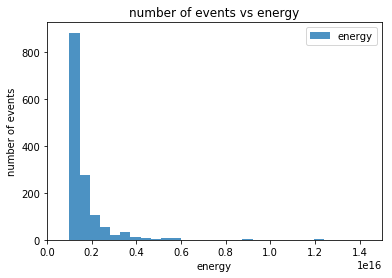

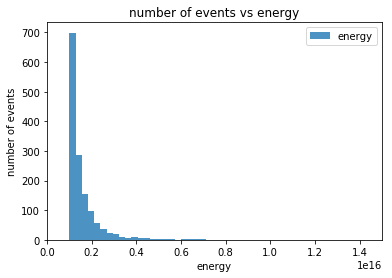

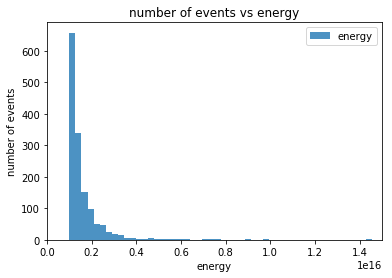

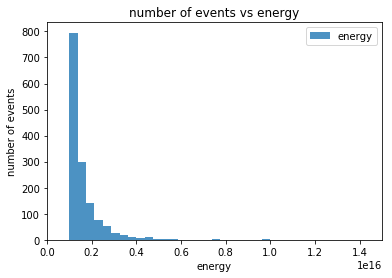

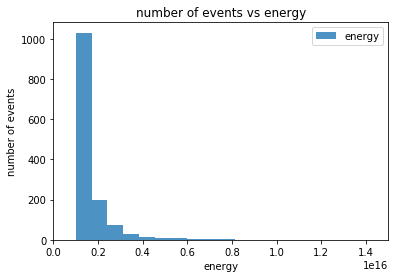

In [5]:
for name, group in groups:
    fig, axe =plt.subplots()
    group.energy.plot.hist(bins=50,alpha=0.8,legend=True)
    axe.set_xlim(0,1.5*10**16)
    plt.xlabel('energy')
    plt.ylabel('number of events')
    plt.title('number of events vs energy')

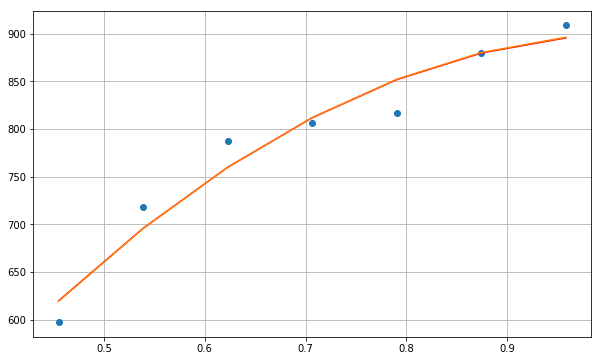

In [11]:

fig2, ax2 =plt.subplots(figsize=(10,6))
plt.grid()
from utils import get_s125 
a1=values[0]
a2=values[1]
a3=values[2]
y=get_s125(bins2, a1,a2,a3)
y2=get_s125(bins2, alpha, beta, a3)

ax2.plot(bins2, s125_fit, lw=0, marker='o')
ax2.plot(bins2,y, color="r")
ax2.plot(bins2,y2)

In [ ]:
#groups = dict(list(data))
#print(groups)
for name, group in groups:
    fig, axes =plt.subplots(figsize=(8,5))
    group.plot(x='s125',y='I',legend=True)
    axes.set_xscale('log')
    axes.set_yscale('log')
    plt.xlabel('s125')
    plt.ylabel('intensity')
    plt.title('intensity vs s125')



(2, 4)

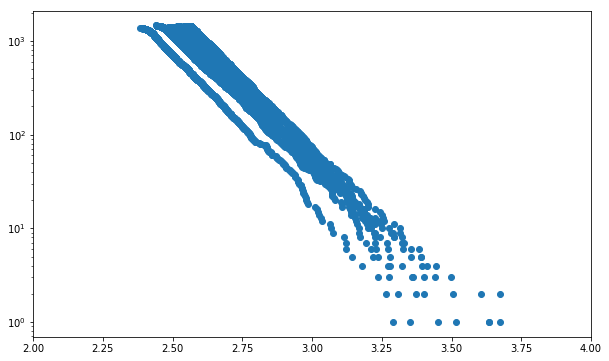

In [16]:
fig1, ax1 =plt.subplots(figsize=(10,6))
ax1.plot(np.log10(data.s125),data.I, lw=0, marker='o' )
ax1.set_yscale('log')
ax1.set_xlim(2,4)

In [ ]:
### number of boostrap samples as input

intensity2=[100,200,300]
samples = 2
from data_functions import get_s125

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
a=[alpha,beta,1]
bootstrap_values=[]
bootstrap_values_2=[]
fitted_data=pd.DataFrame([])
#fitted_data['bs125']=[]
for j in range(0, samples):
    new_data = get_bootstrap_data(data)
    new_data=set_intensity(new_data, nr_of_bins)
    for i in range(len(intensity2)):
        val, s125_fit, bins, s125_fit_error = get_data_to_fit(new_data, intensity2[i], nr_of_bins)
        val["sample"]=j
        val["bins"]=np.digitize(bins, bins) 
        fitted_data=fitted_data.append(val)
        vals, cov_bt = get_attenuation_parameters(s125_fit, bins)
        bootstrap_values.append(vals)
        bootstrap_values_2.append(vals**2)
        ax2.plot(bins, s125_fit, lw=0, marker='o')
        ax2.plot(bins, get_s125(bins, vals[0], vals[1], vals[2]))
    print(vals)

In [ ]:
I0=fitted_data.loc[fitted_data.I==100]
nb_bins=I0.bins.max()-I0.bins.min()+1
for i,j in enumerate(intensity2):
    I0=fitted_data.loc[fitted_data.I==j]
    nb_bins=I0.bins.max()-I0.bins.min()+1
    for k in range(1,nb_bins):
        df=fitted_data.loc[fitted_data.bins==k]
        df = df.loc[df.I == j]
    print(df)
    print(df.s125.var())



In [ ]:
### number of boostrap samples as input
samples = 2
from data_funcs import get_s125

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
a=[alpha,beta,1]
bootstrap_values=[]
bootstrap_values_2=[]
for j in range(0, samples):
    new_data = get_bootstrap_data(data)
    new_data=set_intensity(new_data, nr_of_bins)
    s125_fit, bins, s38_fit, s125_fit_error = get_data_to_fit(new_data, intensity, nr_of_bins)
    vals, cov_bt = get_attenuation_parameters(s125_fit, bins)
    bootstrap_values.append(vals)
    bootstrap_values_2.append(vals**2)
    ax2.plot(bins, s125_fit, lw=0, marker='o')
    ax2.plot(bins, get_s125(bins, vals[0], vals[1], vals[2]))
    print(vals)


Things to do:
1. From the bootstrap get all the values and plot them in an histogram and one vs each other (in one canvas)
2. Give final results: values(from original data) +- rms(vals)
3. Implement MCMC fit in the get_attenuation_parameters function
4. Compare results with 2.
5. See/write to Ioana/Zig

In [ ]:
from data_funcs import get_attenuation_parameters2

params_scipy, cov2 = sp.optimize.curve_fit(get_s125, bins, s125_fit)
# Use as guess
a_true = params_scipy[0]
b_true = params_scipy[1]
f_true = params_scipy[2]

#final_parameters, cov2, sample = get_attenuation_parameters2(s125_fit, s38_fit, s125_fit_error, bins, performMCMC=True)
sample = get_attenuation_parameters2(params_scipy, s125_fit, s125_fit_error, bins)

In [ ]:
import math
cos_ref = np.cos(math.radians(38))**2
cos2 = bins - cos_ref
# Plot a subset of the samples
for a, b, f in sample[np.random.randint(len(sample), size=100)]:
    plt.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="k", alpha=0.1)
    plt.plot(cos2, f_true * (b_true * cos2**2 + a_true * cos2 + 1), color="r", lw=2, alpha=0.8)
    plt.errorbar(cos2, y, yerr=s125_fit_error, fmt=".k")

In [ ]:
import corner
fig = corner.corner(sample, labels=["$a$","$b$", "$s38$"], truths=[alpha,beta, a3])
fig.savefig("")

In [ ]:
a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(sample, [16, 50, 84],
                                                axis=0)))

#(mid_value, +error, -error)
print("a = %f + %f - %f\n"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b = %f + %f - %f\n"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("s38 = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))